### Load Dataset

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
# Read dataset
df = pd.read_csv('./src/AEP_hourly.csv')
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [3]:
# Set datetime into index
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


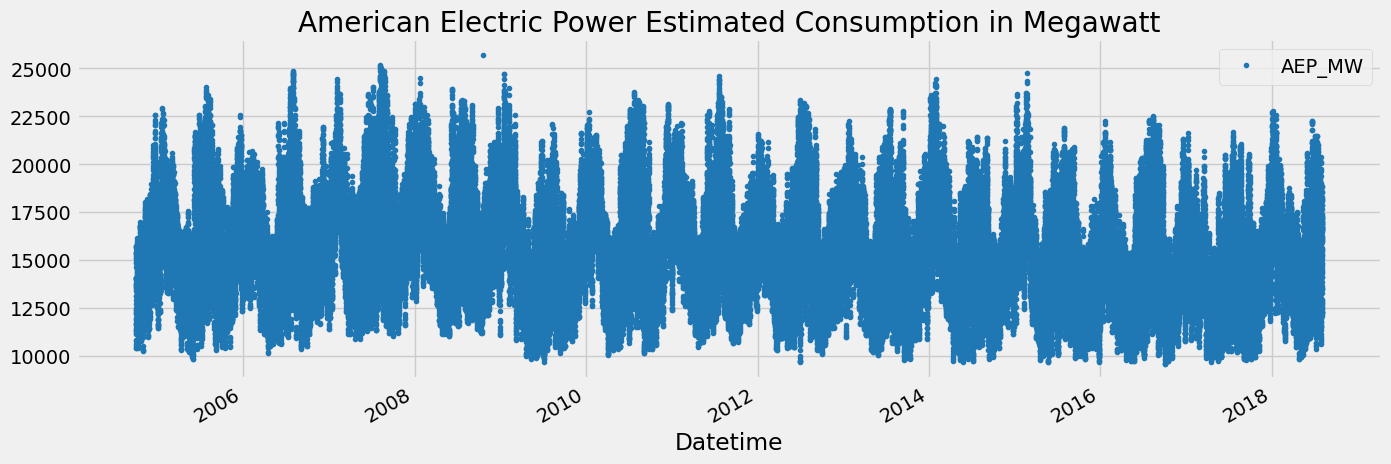

In [4]:
# Plot dataset
df.plot(style='.', figsize=(15, 5), color=color_pal[0], title='American Electric Power Estimated Consumption in Megawatt')
plt.show()

### Checking Outliers

<Axes: ylabel='Frequency'>

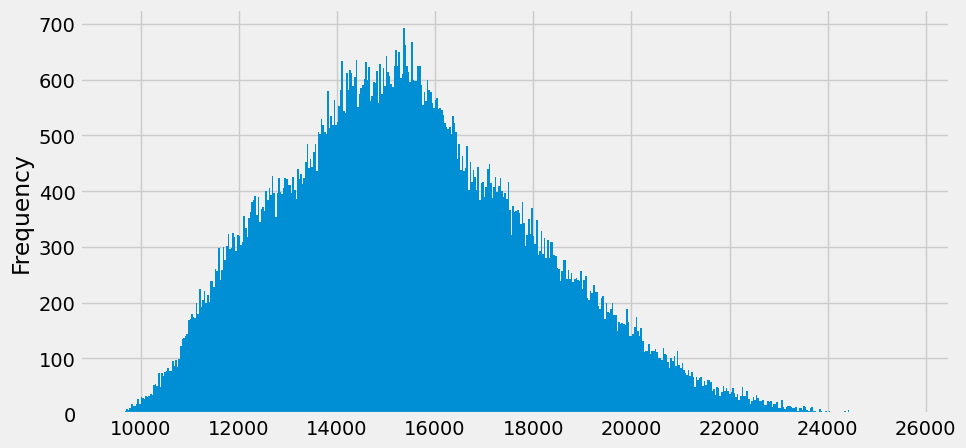

In [5]:
df['AEP_MW'].plot(kind='hist', bins=500, figsize=(10,5))

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

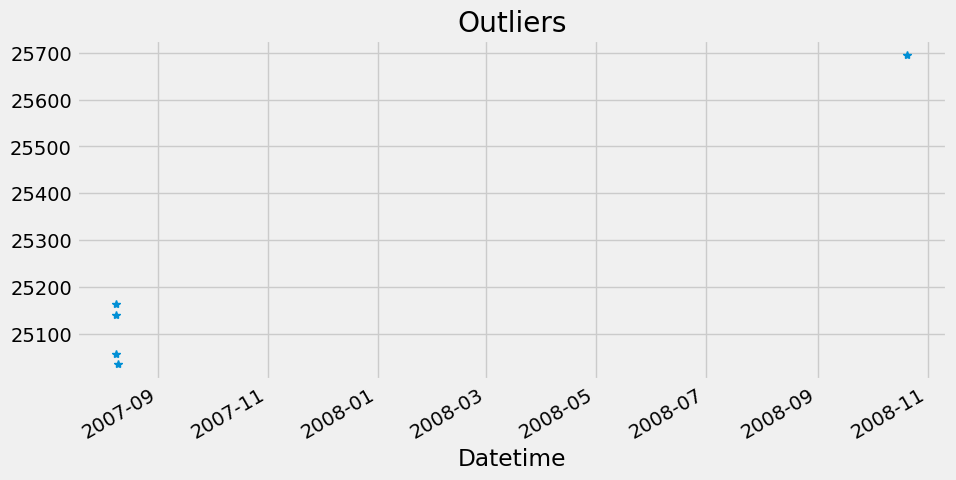

In [6]:
df.query('AEP_MW > 25000')['AEP_MW'].plot(style='*', figsize=(10,5), title='Outliers')

In [7]:
df = df.query('AEP_MW <= 25000').copy()

### Exploratory Data Analysis

In [8]:
# Creating new columns
df = df.copy()
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week

In [9]:
# Create a function for features
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

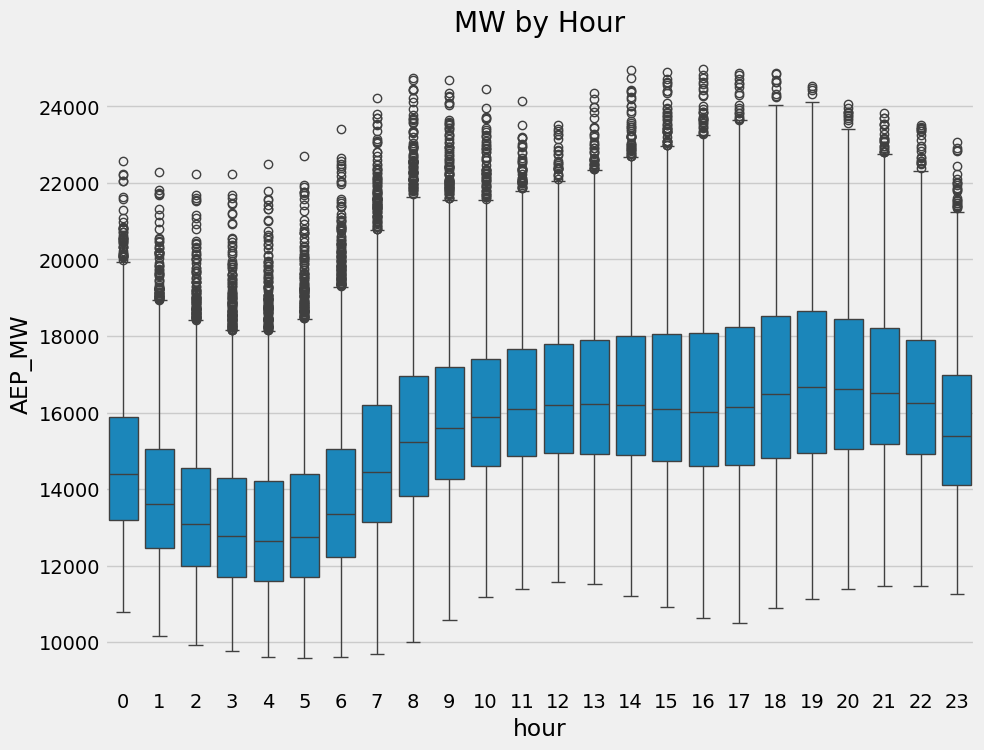

In [10]:
# Exploratory: plot data daily
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

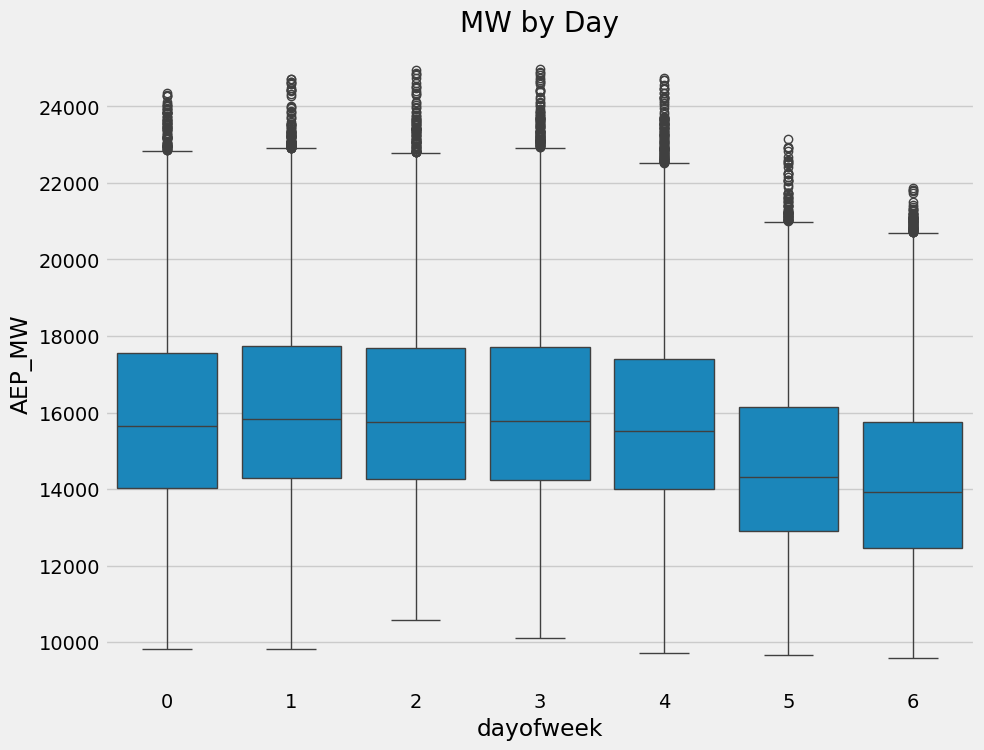

In [11]:
# Exploratory: plot data weekly
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='AEP_MW')
ax.set_title('MW by Day')
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_3160\1504655231.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')


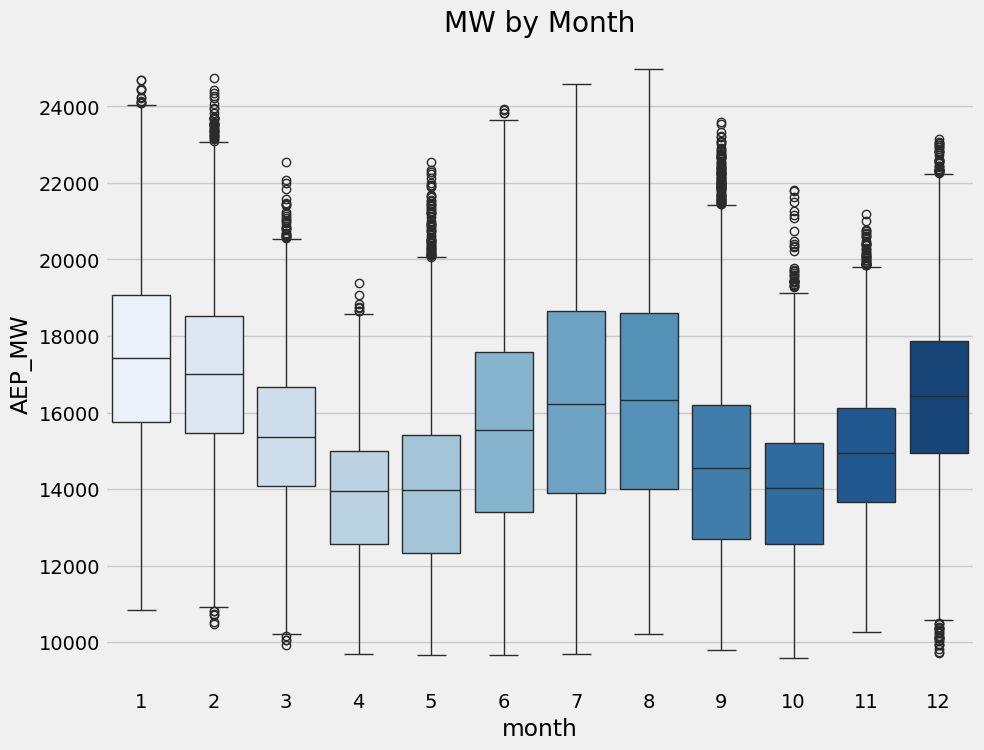

In [12]:
# Exploratory: plot data annualy
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

### Define Timeseries

In [13]:
# Define train set and test set
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

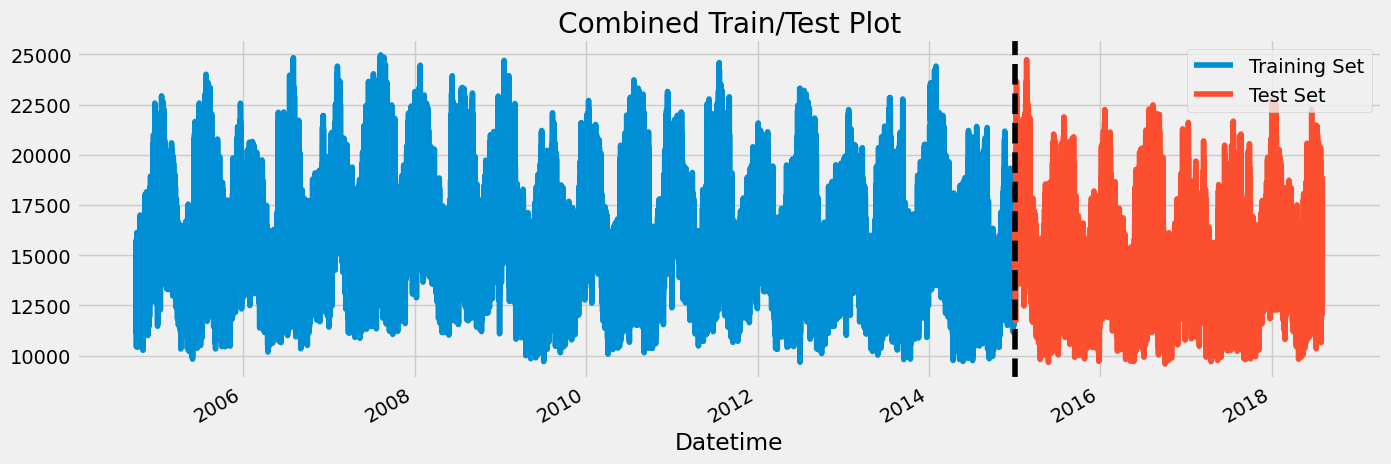

In [14]:
# Plot train and test set
fig, ax = plt.subplots(figsize=(15, 5))
train['AEP_MW'].plot(ax=ax, label='Training Set/Test Set', title='Combined Train/Test Plot')
test['AEP_MW'].plot(ax=ax)
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Cross Validation

In [15]:
# Import Scikitlearn
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

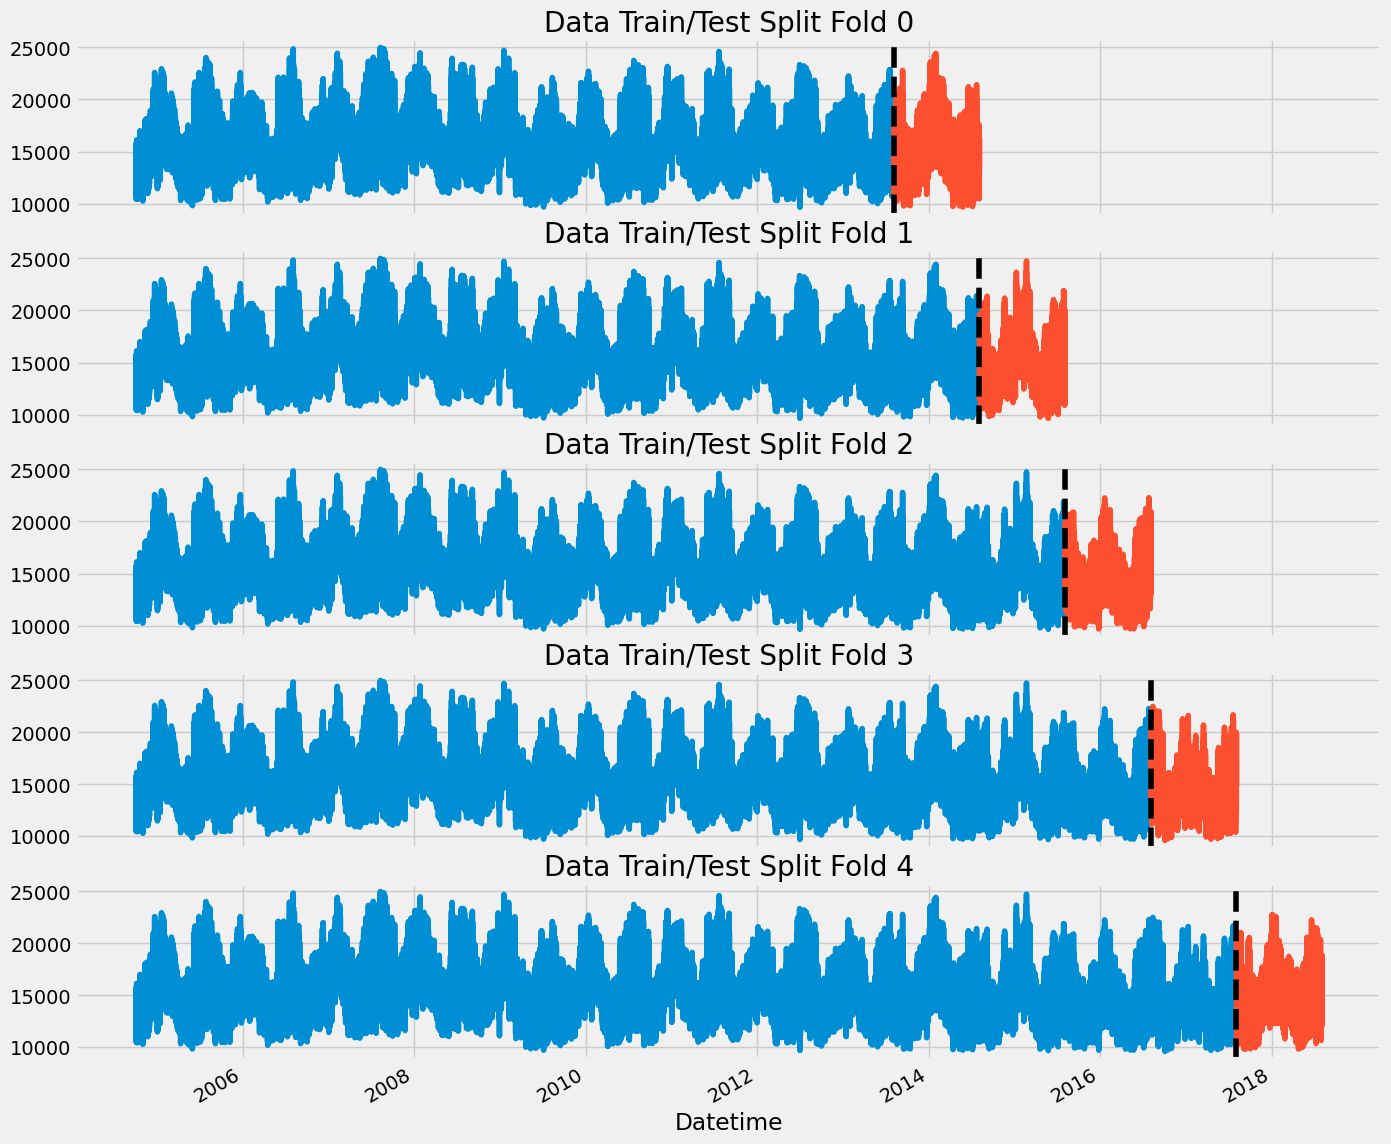

In [16]:
# Plot fold
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['AEP_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['AEP_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### Lag Features

In [17]:
# Define lags
def add_lags(df):
    target_map = df['AEP_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df = add_lags(df)

### Train - Test

In [18]:
# Train and test the model 
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'AEP_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:15897.60954	validation_1-rmse:15264.21411


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:33:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:6031.05887	validation_1-rmse:5643.35452
[200]	validation_0-rmse:2654.54993	validation_1-rmse:2430.14789
[300]	validation_0-rmse:1708.87372	validation_1-rmse:1644.20944
[400]	validation_0-rmse:1489.78120	validation_1-rmse:1552.17998
[457]	validation_0-rmse:1449.14695	validation_1-rmse:1555.36895
[0]	validation_0-rmse:15834.75592	validation_1-rmse:15221.95474


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:6007.48503	validation_1-rmse:5715.46535
[200]	validation_0-rmse:2645.28938	validation_1-rmse:2505.67306
[300]	validation_0-rmse:1707.83917	validation_1-rmse:1616.95138
[400]	validation_0-rmse:1501.43679	validation_1-rmse:1453.89865
[500]	validation_0-rmse:1443.07134	validation_1-rmse:1430.35581
[600]	validation_0-rmse:1411.16556	validation_1-rmse:1428.48978
[616]	validation_0-rmse:1407.77112	validation_1-rmse:1428.58028
[0]	validation_0-rmse:15778.60402	validation_1-rmse:14549.73821


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5985.26078	validation_1-rmse:5100.75419
[200]	validation_0-rmse:2635.42219	validation_1-rmse:2054.05232
[300]	validation_0-rmse:1703.30825	validation_1-rmse:1505.39145
[372]	validation_0-rmse:1530.57446	validation_1-rmse:1517.66099
[0]	validation_0-rmse:15678.84243	validation_1-rmse:14632.67515


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:33:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5950.08777	validation_1-rmse:5460.97405
[200]	validation_0-rmse:2627.55371	validation_1-rmse:2469.63530
[300]	validation_0-rmse:1707.34108	validation_1-rmse:1780.14848
[400]	validation_0-rmse:1506.43881	validation_1-rmse:1662.26046
[500]	validation_0-rmse:1445.96109	validation_1-rmse:1654.83274
[600]	validation_0-rmse:1419.58009	validation_1-rmse:1648.49953
[617]	validation_0-rmse:1415.97911	validation_1-rmse:1649.39743
[0]	validation_0-rmse:15600.22862	validation_1-rmse:15012.55405


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:33:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5924.61512	validation_1-rmse:5859.38352
[200]	validation_0-rmse:2626.51278	validation_1-rmse:2775.19814
[300]	validation_0-rmse:1716.84740	validation_1-rmse:1900.17084
[400]	validation_0-rmse:1515.39342	validation_1-rmse:1712.25571
[500]	validation_0-rmse:1456.93093	validation_1-rmse:1700.34348
[528]	validation_0-rmse:1447.73645	validation_1-rmse:1703.71103


In [19]:
# Print scores
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1563.7762
Fold scores:[1551.2613103045057, 1426.592046226638, 1496.3897693573754, 1646.998569973056, 1697.6390736669064]


### Prediction


In [20]:
# Prediction
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

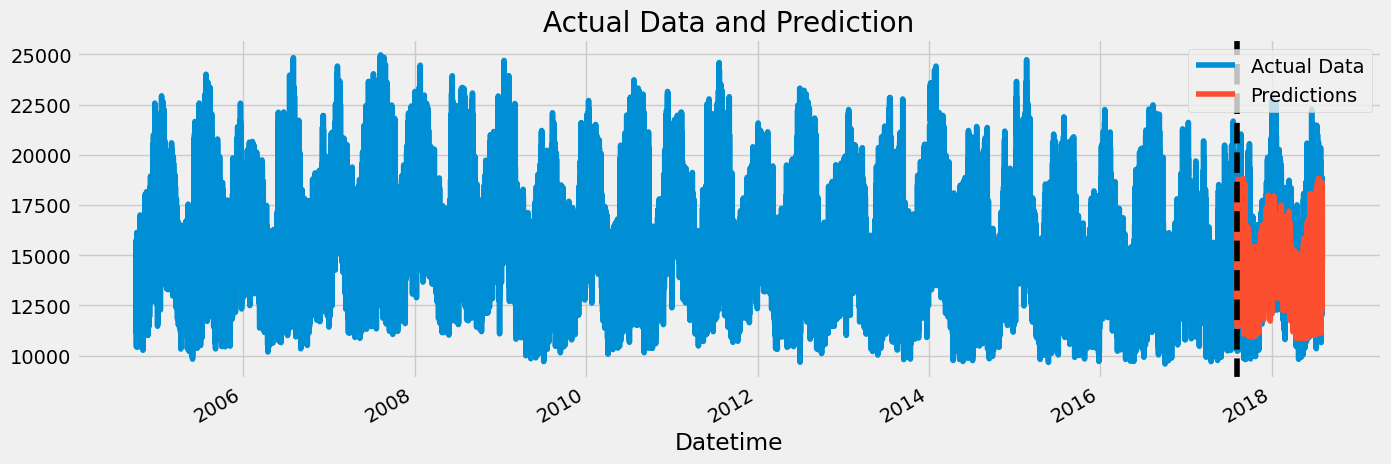

In [21]:
# Plot prediction results
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='-')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Actual Data and Prediction')
ax.axvline(test.index.min(), color='black', ls='--')
plt.show()

### Predict the Future

In [22]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'AEP_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:15558.43430


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:33:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5908.43514
[200]	validation_0-rmse:2622.04190
[300]	validation_0-rmse:1721.93995
[400]	validation_0-rmse:1522.64392
[499]	validation_0-rmse:1470.76111


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [23]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()

In [24]:
# Predict
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

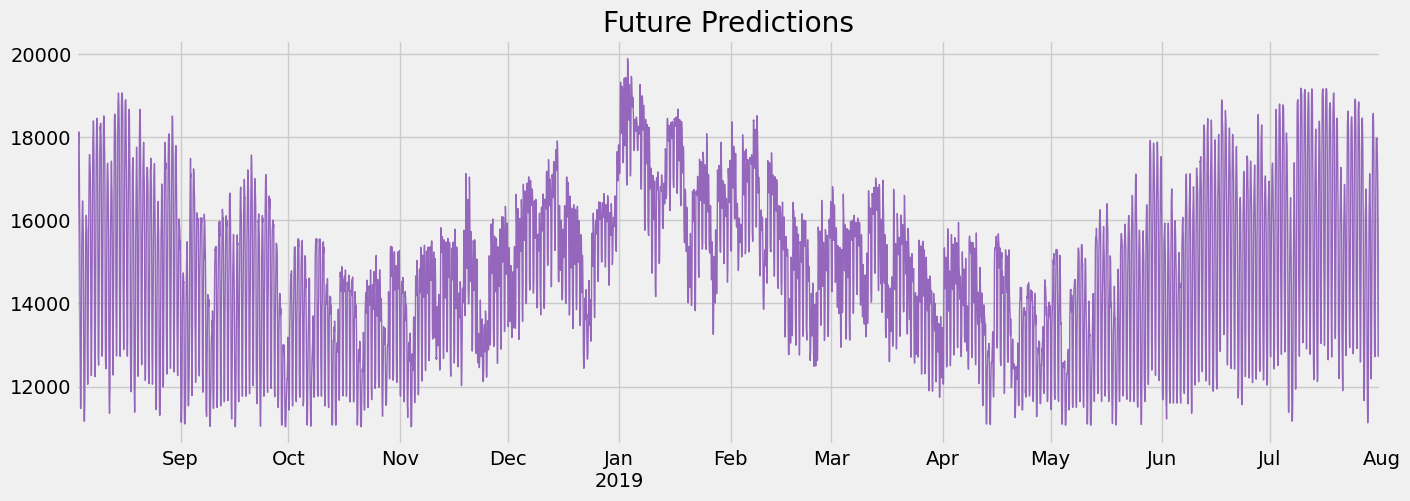

In [27]:
# Plot prediction
future_w_features['pred'].plot(figsize=(15, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

### Save the Model

In [26]:
# Save model
reg.save_model('model.json')